In [397]:
import matplotlib.pyplot as plt
import numpy as np
#!pip install -U numba
from numba import jit
from scipy.stats import multivariate_normal
import random as rn
import eif as iso
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed
import time
import eif_old as iso2
import seaborn as sb
from sklearn.ensemble import IsolationForest

In [398]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")
import eif_new as iso_new

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [644]:
# Create data
mean = [0, 0, 0 ]
cov = [[1, 0, 0.], [0, 0.1, 0.0], [0,0,1]]  # diagonal covariance
Nobjs = 5000
np.random.seed(1)
x, y, z = np.random.multivariate_normal(mean, cov, Nobjs).T
# Add manual outlier
x[0] = 3.3
y[0] = 3.3
z[0] = 3.3
X = np.array([x,y,z]).T

In [400]:
# Generate train data
#X = 0.3 * np.random.randn(1000, 10)

In [645]:
rng = 42
Ntrees = 500
Nsamples = 256

In [646]:
# scikit learn solution
ss = time.time()
F0 = IsolationForest(n_estimators=Ntrees, max_samples=Nsamples, random_state=rng).fit(X)
S0 = F0.score_samples(X)*-1
ee = time.time()
print('{:.3f} sec, Scikit Learn'.format(ee-ss))

0.933 sec, Scikit Learn


In [647]:
ss = time.time()
F1 = iso.iForest(X, ntrees=Ntrees, sample_size=Nsamples, ExtensionLevel=0, seed=rng)
S1 = F1.compute_paths(X_in=X)
ee = time.time()
print('{:.3f} sec, EIF Cython Version'.format(ee-ss))

1.260 sec, EIF Cython Version


In [687]:
ss = time.time()
F2 = iso2.iForest(X, ntrees=Ntrees, sample_size=Nsamples, ExtensionLevel=0)
S2 = F2.compute_paths(X_in=X)
ee = time.time()
print('{:.3f} sec, EIF Old Python Version'.format(ee-ss)) # 422 sec vs 15 new

43.727 sec, EIF Old Python Version


In [719]:
import eif_new as iso_new
ss = time.time()
F3 = iso_new.iForest(ntrees=Ntrees, sample=Nsamples, exlevel=0, random_state=rng).fit(X)
S3 = F3.compute_paths(X)
ee = time.time()
print('{:.3f} sec, EIF New Python Version'.format(ee-ss)) 
# 6.309 sec, EIF New Python Version
# 3.402 sec, EIF New Python Version score_samples0
# 5.821 sec, EIF New Python Version score_samples
# 2.097 sec, EIF New Python Version score_samples1 5000x3
# 1.603 sec, EIF New Python Version
# 1.314 sec, EIF New Python Version without using childs
# 1.300 sec, EIF New Python Version without using childs
# 1.219 sec, EIF New Python Version

1.214 sec, EIF New Python Version


Text(0.5, 0, 'Scores')

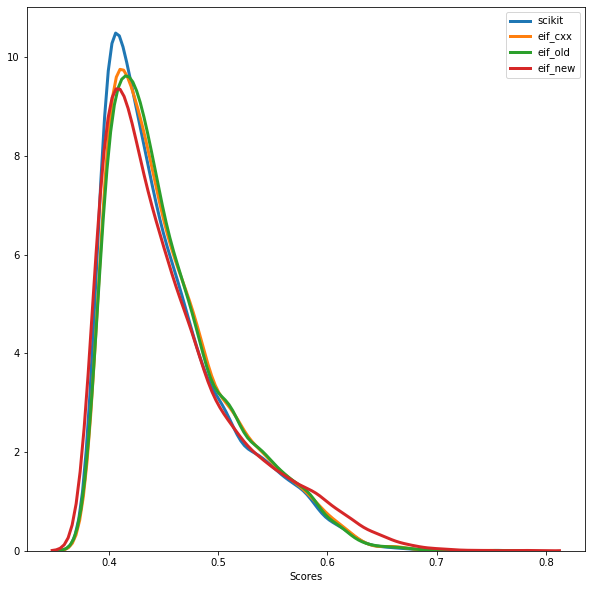

In [689]:
plt.figure(figsize=(10,10))
sb.kdeplot(S0, lw=3, label='scikit', clip=(0.35, 0.8))
sb.kdeplot(S1, lw=3, label='eif_cxx', clip=(0.35, 0.8))
sb.kdeplot(S2, lw=3, label='eif_old', clip=(0.35, 0.8))
sb.kdeplot(S3, lw=3, label='eif_new', clip=(0.35, 0.8))
plt.legend(loc=0)
plt.xlabel('Scores')

In [672]:
import joblib, os
from datetime import datetime
ext = "jbl"

t0 = datetime.now()
jbl_fn = "eif_new.%s"%ext
joblib.dump(F3, jbl_fn)
dt = datetime.now()-t0
print("%s %.2f Mb"%(dt, os.stat(jbl_fn).st_size/1024**2)) # 0:00:00.877536 0.56 Mb
# 0:00:00.407903 0.28 Mb f2 0.44 Mb f4
# 0:00:00.079145 5.49 Mb f4 u2
# 0:00:00.079248 6.95 Mb f4 i4
# 0:00:00.005211 4.39 Mb f4 u2 without using childs

0:00:00.005211 4.39 Mb


In [80]:
t0 = datetime.now()
jbl_fn = "eif_old.%s"%ext
joblib.dump(F2, jbl_fn)
dt = datetime.now()-t0
print("%s %.2f Mb"%(dt, os.stat(jbl_fn).st_size/1024**2)) #0:00:32.724675 6.83 Mb
# 0:00:17.224409 3.54 Mb
# 0:00:08.227051 42.72 Mb no compression

0:00:08.227051 42.72 Mb


In [715]:
@jit
def power2(n):
    """Return 2^n"""
    return 2**n

%timeit power2(np.arange(50))
%timeit np.power(2, np.arange(50))

922 ns ± 6.82 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.2 µs ± 8.26 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [710]:
1/200/3 == 1/200 *1/3

True

In [718]:
import eif_new as iso_new #Ntrees
F3 = iso_new.iForest(ntrees=Ntrees, sample=Nsamples, random_state=rng, exlevel=0).fit(X)
S3 = F3.compute_paths(X)

In [717]:
%timeit iso_new.iForest(ntrees=Ntrees, sample=Nsamples, random_state=rng, exlevel=0).fit(X) #X.shape[1]-1)
%timeit F3.compute_paths(X)
# 749 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) exlevel=0
# 361 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) without p *min-max

# 2.46 s ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 1.75 s ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) nonzero instead of argwhere
# 1.65 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) without nonzero
# 1.36 s ± 4.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) X.dot for all nodes
# 1.99 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) get_paths0

# 752 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) exlevel=2
# 2.48 s ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) 

#707 ms ± 5.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#1.51 s ± 7.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# 623 ms ± 4.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 1.44 s ± 6.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# 600 ms ± 561 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 1.44 s ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# 452 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) jit minmax
# 1.38 s ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# 399 ms ± 6.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 1.35 s ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#308 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
#935 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


307 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
922 ms ± 3.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [615]:
size = 500
w = np.random.choice([False, True], size=size); w
a, b = np.zeros(size), np.ones(size)
ni = np.random.choice(np.arange(511), size)
e = 3

In [653]:
import eif_new as iso_new #Ntrees
F3 = iso_new.iForest(ntrees=Ntrees, sample=Nsamples, random_state=rng, exlevel=0).fit(X)
#%timeit F3.fit(X)
%timeit F3.score_samples_without_using_childidx(X)
%timeit F3.score_samples(X)


# 1.25 s ± 792 µs per loop (mean ± std. dev. of 7 runs, 1 loop each) # score_empty
# 1.55 s ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# 1.79 s ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) update_nodes jit
# 1.43 s ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) update_nodes loop jit
# 1.09 s ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# 911 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) score jit

925 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.23 s ± 3.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [682]:
#!pip install line_profiler
%load_ext line_profiler
%lprun -f F3.populate_nodes F3.fit(X)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [654]:
#!pip install line_profiler
%load_ext line_profiler
#%lprun -f F3.populate_nodes F3.fit(X)
%lprun -f F3.score_samples_without_using_childidx F3.score_samples_without_using_childidx(X)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
   243      5000      36145.0      7.2      2.2              ni[w] += 1
   244      5000      34944.0      7.0      2.1              ni[~w] += 2**self.limit
   245      5000      13052.0      2.6      0.8              tidx = np.arange(trees.shape[0])
   246     40000      20187.0      0.5      1.2              for e in range(1, self.limit):
   247     35000     503963.0     14.4     30.4                  w = X[xi].dot(n[tidx, ni].T) < pdotn[tidx, ni]
   248     35000     224162.0      6.4     13.5                  ni[w] += 1
   249     35000     231092.0      6.6     13.9                  ni[~w] += 2**(self.limit-e)
   250     35000     153654.0      4.4      9.3                  sel = sizes[tidx, ni]>1
   251     35000     199838.0      5.7     12.0                  S[xi] += e*(~sel).sum()
   252     35000      90068.0      2.6      5.4                  tidx, ni = tidx[sel], ni[sel]
   253                                                       # the size matters only at terminal nodes
   254      5000      13812.0      2.8      0.8              size = sizes[tidx, ni]
   255      5000      74718.0     14.9      4.5              S[xi] += self.limit*len(ni) + c_factor(size[size>1]).sum()


   245      5000       8827.0      1.8      0.7              ni = update_nodes(ni, w, self.limit, 0)
   251     35000      55862.0      1.6      4.4                  ni = update_nodes(ni, w, self.limit, e)    

   248     35000      66392.0      1.9      6.3                  S[xi] += score_false(e, sel) #e*(~sel).sum()
   252      5000      49817.0     10.0      4.0              S[xi] += score_terminal(self.limit, ni, size) #self.limit*len(ni) + c_factor(size[size>1]).sum()


In [666]:
import eif_new as iso_new #Ntrees
F3 = iso_new.iForest(ntrees=Ntrees, sample=Nsamples, random_state=rng, exlevel=0).fit(X)
%timeit F3.fit(X)
%timeit F3.score_samples(X)
%timeit F3.score_samples_without_using_childidx(X)

# 394 ms ± 5.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 1.4 s ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# 395 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 1.25 s ± 792 µs per loop (mean ± std. dev. of 7 runs, 1 loop each) # score_empty

#404 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#926 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#393 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#1.22 s ± 6.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#398 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#1.21 s ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#897 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


396 ms ± 4.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.24 s ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
915 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [667]:
#!pip install line_profiler
%load_ext line_profiler
#%lprun -f F3.populate_nodes F3.fit(X)
%lprun -f F3.score_samples F3.score_samples(X)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
   197      5000      70606.0     14.1      4.4              ni = np.where(X[xi].dot(n[:, 0].T) < pdotn[:, 0], left[:, 0].T, right[:, 0].T)
   203     35000     393205.0     11.2     24.7                  ni = np.where(w, left[tidx, ni].T, right[tidx, ni].T)    


   197      5000      60670.0     12.1      3.8              ni = where(X[xi].dot(n[:, 0].T) < pdotn[:, 0], left[:, 0].T, right[:, 0].T)
   203     35000     384696.0     11.0     24.0                  ni = where(w, left[tidx, ni].T, right[tidx, ni].T)    

   205     35000     228445.0      6.5     14.8                  S[xi] += e*(ni==0).sum()
   210     35000      64396.0      1.8      4.7                  S[xi] += score_empty(e, ni) #e*(ni==0).sum()

   217      5000      82895.0     16.6      6.0              S[xi] += self.limit*len(ni) + c_factor(size[size>1]).sum()
   222      5000      49138.0      9.8      3.7              S[xi] += score_terminal(self.limit, ni, size) #self.limit*len(ni) + c_factor(size[size>1]).sum()




In [391]:
#%prun score_samples_by_sample_pool(X, trees, 6)

In [428]:
def worker(args):
    Xi = args
    ni = 0
    S = 0
    tidx = np.arange(trees.shape[0])
    for e in range(F3.limit):
        pni = ni
        ni = np.where(Xi.dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni], trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
        sel = ni>0
        if e: S += e*(~sel).sum()
        tidx, ni = tidx[sel], ni[sel]
    # the size matters only at terminal nodes
    size = trees[tidx, ni]["size"]
    S += e*len(ni) + c_factor(size[size>1]).sum()  
    return S

def score_samples_by_sample_pool(X, trees, nproc=6):
    S = np.zeros(X.shape[0])
    import multiprocessing as mp
    with mp.Pool(nproc) as p:
        iterable = (X[xi] for xi in range(X.shape[0]))
        for i, si in enumerate(p.imap(worker, iterable, 100)):
            S[i] = si
    return S/len(trees)

#%timeit score_samples_by_sample_pool(X, trees, 1) #1.96 s ± 50.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#%timeit score_samples_by_sample_pool(X, trees, 6) #  484 ms ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
for i in range(1, 13):
    print(i)
    %timeit score_samples_by_sample_pool(X, trees, i) #  484 ms ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

1
2.02 s ± 771 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2
1.07 s ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3
740 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4
652 ms ± 626 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
5
562 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6
577 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7
587 ms ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8
562 ms ± 49.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9
543 ms ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10
555 ms ± 43.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11
553 ms ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12
537 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [431]:
%prun score_samples_by_sample(X, trees)

In [674]:
w = np.random.choice([True, False], size=X.shape[0]), X.shape

In [675]:
%timeit X[w], X[~w]

97.6 µs ± 60.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [679]:
@jit
def split(x, w):
    a = np.empty_like(x)
    b = np.empty_like(x)
    k = l = 0
    for i in range(len(x)):
        if w[i]: 
            a[k] = x[i]
            k += 1
        else:
            b[l] = x[i]
            l += 1
    return a[:k], b[:l]

%timeit split(X, w) #70.8 µs ± 44.6 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
%timeit X[w], X[~w] #97.6 µs ± 60.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

70.8 µs ± 44.6 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
